In [1]:
# Import Necessary packages
import kaggle as kg
import pandas as pd
import numpy as np

In [2]:
# 1) Obtain Kaggle API JSON file and store in "C:\Users\username\.kaggle\kaggle.json"
# 2) identify dataset and store in local path "...\seattle_airbnb.zip" and "...\boston_airbnb.zip" folder
kg.api.authenticate()
kg.api.dataset_download_files(dataset="airbnb/seattle", path='seattle_airbnb.zip', unzip=True) #download seattle airbnb files
kg.api.dataset_download_files(dataset="airbnb/boston", path='boston_airbnb.zip', unzip=True) #download boston airbnb files

In [3]:
# Read files

# Boston airbnb
boston_calendar = pd.read_csv('boston_airbnb.zip/calendar.csv', encoding='ISO-8859-1') # calendar
boston_listings = pd.read_csv('boston_airbnb.zip/listings.csv', encoding='ISO-8859-1') # listings
boston_reviews = pd.read_csv('boston_airbnb.zip/reviews.csv', encoding='ISO-8859-1') # reviews

# Seattle airbnb
seattle_calendar = pd.read_csv('seattle_airbnb.zip/calendar.csv', encoding='ISO-8859-1') # calendar
seattle_listings = pd.read_csv('seattle_airbnb.zip/listings.csv', encoding='ISO-8859-1') # listings
seattle_reviews = pd.read_csv('seattle_airbnb.zip/reviews.csv', encoding='ISO-8859-1') # reviews

In [4]:
# Create column to identify region
boston_calendar['City1'] = "Boston"
seattle_calendar['City1'] = "Seattle"

boston_listings['City2'] = "Boston"
seattle_listings['City2'] = "Seattle"

In [5]:
# Append files
df_calendar = boston_calendar.append(seattle_calendar)
df_listings = boston_listings.append(seattle_listings)

In [6]:
# Occupancy rates by listing
df_calendar.dtypes

listing_id     int64
date          object
available     object
price         object
City1         object
dtype: object

In [7]:
df_calendar.head()

,listing_id,date,available,price,City1
0,12147973,2017-09-05,f,NaN,Boston
1,12147973,2017-09-04,f,NaN,Boston
2,12147973,2017-09-03,f,NaN,Boston
3,12147973,2017-09-02,f,NaN,Boston
4,12147973,2017-09-01,f,NaN,Boston


In [8]:
# Create dataframe to identify number of days when occupied (available = 'f'), total days on market and occupancy rate
from pandasql import sqldf

# write query
q = """SELECT df_calendar.listing_id, 
count(df_calendar.available) as occupied_days, 
o.total_days as total_days
FROM df_calendar
LEFT JOIN(SELECT listing_id, count(available) as total_days
FROM df_calendar
GROUP BY listing_id) as o
on df_calendar.listing_id = o.listing_id
WHERE df_calendar.available = 'f'
GROUP BY df_calendar.listing_id
"""
pysqldf = lambda q: sqldf(q, globals())
df_calendar_occ = pysqldf(q)

# add column for occupancy rate
df_calendar_occ['Occupancy_Rate'] = df_calendar_occ['occupied_days'] / df_calendar_occ['total_days']

In [41]:
# Merge to listings dataframe

# write query
q = """SELECT df_listings.*, 
df_calendar_occ.occupied_days, 
df_calendar_occ.total_days,
df_calendar_occ.Occupancy_Rate
FROM df_listings
LEFT JOIN df_calendar_occ
on df_listings.id = df_calendar_occ.listing_id"""
pysqldf = lambda q: sqldf(q, globals())
df_master = pysqldf(q)

In [42]:
# import packages for statistical analysis
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [43]:
# Clean price columns
df_master['price_num'] = df_master['price'].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)

In [44]:
# Drop nulls - Rows where occupancy rate is null
df_master_nullocc = df_master.dropna(subset=['Occupancy_Rate'])

In [45]:
### Does occupancy rate differ among each market

In [46]:
np.mean(df_master_nullocc['Occupancy_Rate'])

0.46528011650662077

In [47]:
df_master_nullocc.groupby('City2').agg({'Occupancy_Rate': ['mean', 'count']})

Occupancy_Rate      
                  mean count
City2                       
Boston        0.523686  3482
Seattle       0.400513  3140

In [48]:
### How does price impact occupancy rate? And does it differ by market?

                            OLS Regression Results                            
Dep. Variable:         Occupancy_Rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9258
Date:                Fri, 15 Oct 2021   Prob (F-statistic):              0.336
Time:                        09:41:24   Log-Likelihood:                -2832.1
No. Observations:                6622   AIC:                             5668.
Df Residuals:                    6620   BIC:                             5682.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4600      0.007     64.296      0.0

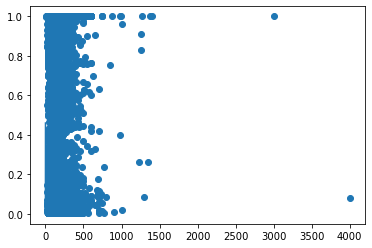

In [49]:
# All data
# Subset data
X = df_master_nullocc['price_num']
Y = df_master_nullocc['Occupancy_Rate']
# OLS regression
results = sm.OLS(Y,sm.add_constant(X)).fit()
# OLS summary
print(results.summary())
# Print scatter plot
plt.scatter(X,Y)
# fit regression results to scatter plot
X_plot = np.linspace(0,1,100)
plt.plot(X_plot, X_plot*results.params[0] + results.params[1])
# Print
plt.show()

In [50]:
# Subset data into Boston and Seattle
df_master_seattle = df_master[df_master['City2'] == 'Seattle'] # Seattle
df_master_boston = df_master[df_master['City2'] == 'Boston'] # Boston

In [51]:
# Drop nulls - Rows where occupancy rate is null
df_master_seattle_nullocc = df_master_seattle.dropna(subset=['Occupancy_Rate'])
df_master_boston_nullocc = df_master_boston.dropna(subset=['Occupancy_Rate'])

                            OLS Regression Results                            
Dep. Variable:         Occupancy_Rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3846
Date:                Fri, 15 Oct 2021   Prob (F-statistic):              0.535
Time:                        09:41:25   Log-Likelihood:                -1102.1
No. Observations:                3140   AIC:                             2208.
Df Residuals:                    3138   BIC:                             2220.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3951      0.011     37.207      0.0

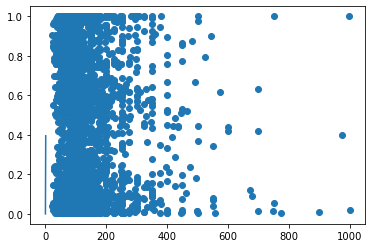

In [52]:
# Seattle
# Subset data
X = df_master_seattle_nullocc['price_num']
Y = df_master_seattle_nullocc['Occupancy_Rate']
# OLS regression
results = sm.OLS(Y,sm.add_constant(X)).fit()
# OLS summary
print(results.summary())
# Print scatter plot
plt.scatter(X,Y)
# fit regression results to scatter plot
X_plot = np.linspace(0,1,100)
plt.plot(X_plot, X_plot*results.params[0] + results.params[1])
# Print
plt.show()

                            OLS Regression Results                            
Dep. Variable:         Occupancy_Rate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.806
Date:                Fri, 15 Oct 2021   Prob (F-statistic):             0.0511
Time:                        09:41:26   Log-Likelihood:                -1615.0
No. Observations:                3482   AIC:                             3234.
Df Residuals:                    3480   BIC:                             3246.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5387      0.010     53.493      0.0

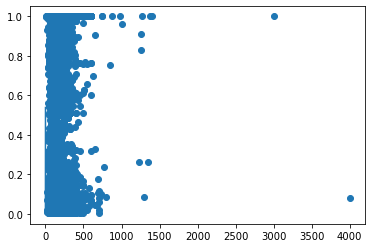

In [53]:
# Seattle
# Subset data
X = df_master_boston_nullocc['price_num']
Y = df_master_boston_nullocc['Occupancy_Rate']
# OLS regression
results = sm.OLS(Y,sm.add_constant(X)).fit()
# OLS summary
print(results.summary())
# Print scatter plot
plt.scatter(X,Y)
# fit regression results to scatter plot
X_plot = np.linspace(0,1,100)
plt.plot(X_plot, X_plot*results.params[0] + results.params[1])
# Print
plt.show()

In [54]:
### How does property type impact occupancy rate and price? and does it differ by market?

In [55]:
# Occupancy rate by room type

In [56]:
# All
df_master_nullocc.groupby('room_type').agg({'Occupancy_Rate': ['mean', 'count']})

Occupancy_Rate      
                          mean count
room_type                           
Entire home/apt       0.469072  4297
Private room          0.462869  2181
Shared room           0.388642   144

In [57]:
# Seattle
df_master_seattle_nullocc.groupby('room_type').agg({'Occupancy_Rate': ['mean', 'count']})

Occupancy_Rate      
                          mean count
room_type                           
Entire home/apt       0.414556  2209
Private room          0.373507   857
Shared room           0.294076    74

In [58]:
# Boston
df_master_boston_nullocc.groupby('room_type').agg({'Occupancy_Rate': ['mean', 'count']})

Occupancy_Rate      
                          mean count
room_type                           
Entire home/apt       0.526748  2088
Private room          0.520711  1324
Shared room           0.488611    70

In [59]:
# Occupancy rate by property type

In [60]:
# All
df_prop_all = df_master_nullocc.groupby('property_type').agg({'Occupancy_Rate': ['mean', 'count']}) # Groupby
df_prop_all.columns = ['mean', 'count'] # rename columns
df_prop_all[df_prop_all['count'] >= 10].sort_values(by=['mean'], ascending=False) # sort by with count over ten

,mean,count
property_type,,
Condominium,0.592457,300
Townhouse,0.529867,142
Loft,0.501629,74
Apartment,0.491169,3999
House,0.395186,1928
Camper/RV,0.369315,10
Bungalow,0.358157,11
Cabin,0.336986,21
Bed & Breakfast,0.334594,63


In [61]:
# Seattle
df_prop_seattle = df_master_seattle_nullocc.groupby('property_type').agg({'Occupancy_Rate': ['mean', 'count']}) # Groupby
df_prop_seattle.columns = ['mean', 'count'] # rename columns
df_prop_seattle[df_prop_seattle['count'] >= 10].sort_values(by=['mean'], ascending=False) # sort by with count over ten

,mean,count
property_type,,
Condominium,0.517919,74
Townhouse,0.489918,89
Bed & Breakfast,0.433949,23
Apartment,0.407217,1452
House,0.385300,1393
Loft,0.368611,35
Bungalow,0.358157,11
Cabin,0.336986,21
Other,0.164079,18


In [62]:
# Boston
df_prop_boston = df_master_boston_nullocc.groupby('property_type').agg({'Occupancy_Rate': ['mean', 'count']}) # Groupby
df_prop_boston.columns = ['mean', 'count'] # rename columns
df_prop_boston[df_prop_boston['count'] >= 10].sort_values(by=['mean'], ascending=False) # sort by with count over ten

,mean,count
property_type,,
Loft,0.621005,39
Condominium,0.616863,226
Townhouse,0.596950,53
Apartment,0.539028,2547
House,0.420924,535
Other,0.382779,14
Bed & Breakfast,0.277466,40
Boat,0.175093,11


In [63]:
# All
df_roomprop_all = df_master_nullocc.groupby(['room_type', 'property_type']).agg({'Occupancy_Rate': ['mean', 'count']})
df_roomprop_all.columns = ['mean', 'count'] # rename columns
df_roomprop_all[df_roomprop_all['count'] >= 10].sort_values(by=['mean'], ascending=False) # sort by with count over ten

mean  count
room_type       property_type                   
Entire home/apt Condominium      0.613806    205
Private room    Condominium      0.551429     92
Entire home/apt Loft             0.551283     55
                Townhouse        0.548984     58
Private room    Apartment        0.547721    930
Shared room     Apartment        0.524853     91
Private room    Townhouse        0.513616     83
Entire home/apt Apartment        0.472479   2978
                House            0.425594    927
Private room    House            0.378603    963
                Bed & Breakfast  0.340495     57
Entire home/apt Cabin            0.323973     16
                Bungalow         0.322466     10
                Other            0.321370     10
Private room    Loft             0.308390     16
                Other            0.260274     19
Entire home/apt Boat             0.144152     13
Shared room     House            0.073612     38

In [64]:
### Review score and impact on occupancy? minimum 10 reviews

In [65]:
# All markets

In [66]:
# Drop rows with no reviews
df_master_nullocc_nullscore = df_master_nullocc.dropna(subset=['review_scores_rating'])

In [67]:
# Subset data to include listings with 10+ reviews
df_master_nullocc_nullscore = df_master_nullocc_nullscore.loc[df_master_nullocc_nullscore['number_of_reviews'] > 10]

In [68]:
# Establish bins
bins = pd.cut(df_master_nullocc_nullscore['review_scores_rating'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [69]:
# View data based on bins
df_master_nullocc_nullscore.groupby(bins)['Occupancy_Rate'].agg(['count', 'mean'])

,count,mean
review_scores_rating,,
"(0, 10]",0,NaN
"(10, 20]",0,NaN
"(20, 30]",0,NaN
"(30, 40]",0,NaN
"(40, 50]",0,NaN
"(50, 60]",0,NaN
"(60, 70]",6,0.351142
"(70, 80]",64,0.351884
"(80, 90]",463,0.341407


In [70]:
# Subset data to include listings with 10+ reviews
df_master_nullocc_nullscore2 = df_master_nullocc_nullscore.loc[df_master_nullocc_nullscore['review_scores_rating'] >= 90]

In [75]:
# Establish bins in the 90+ Range
bins2 = pd.cut(df_master_nullocc_nullscore2['review_scores_rating'], [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

In [76]:
# View data based on new bins
df_master_nullocc_nullscore2.groupby(bins2)['Occupancy_Rate'].agg(['count', 'mean'])

,count,mean
review_scores_rating,,
"(90, 91]",128,0.309247
"(91, 92]",148,0.361033
"(92, 93]",187,0.399370
"(93, 94]",221,0.351701
"(94, 95]",292,0.370304
"(95, 96]",335,0.379432
"(96, 97]",311,0.382337
"(97, 98]",346,0.366331
"(98, 99]",199,0.392318
